In [4]:
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [5]:
# Load the dataset
data = pd.read_csv('claims_data.csv')

In [6]:
# Inspect the data
print(data.head())
print(data.describe());
print("missing values:", data.isnull().sum())
print(data.info())

   id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont6     cont7  \
0   1    A    B    A    B    A    A    A    A    B  ...  0.718367  0.335060   
1   2    A    B    A    A    A    A    A    A    B  ...  0.438917  0.436585   
2   5    A    B    A    A    B    A    A    A    B  ...  0.289648  0.315545   
3  10    B    B    A    B    A    A    A    A    B  ...  0.440945  0.391128   
4  11    A    B    A    B    A    A    A    A    B  ...  0.178193  0.247408   

     cont8    cont9   cont10    cont11    cont12    cont13    cont14     loss  
0  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493  0.714843  2213.18  
1  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431  0.304496  1283.60  
2  0.27320  0.26076  0.32446  0.381398  0.373424  0.195709  0.774425  3005.09  
3  0.31796  0.32128  0.44467  0.327915  0.321570  0.605077  0.602642   939.85  
4  0.24564  0.22089  0.21230  0.204687  0.202213  0.246011  0.432606  2763.85  

[5 rows x 132 columns]
                  id 

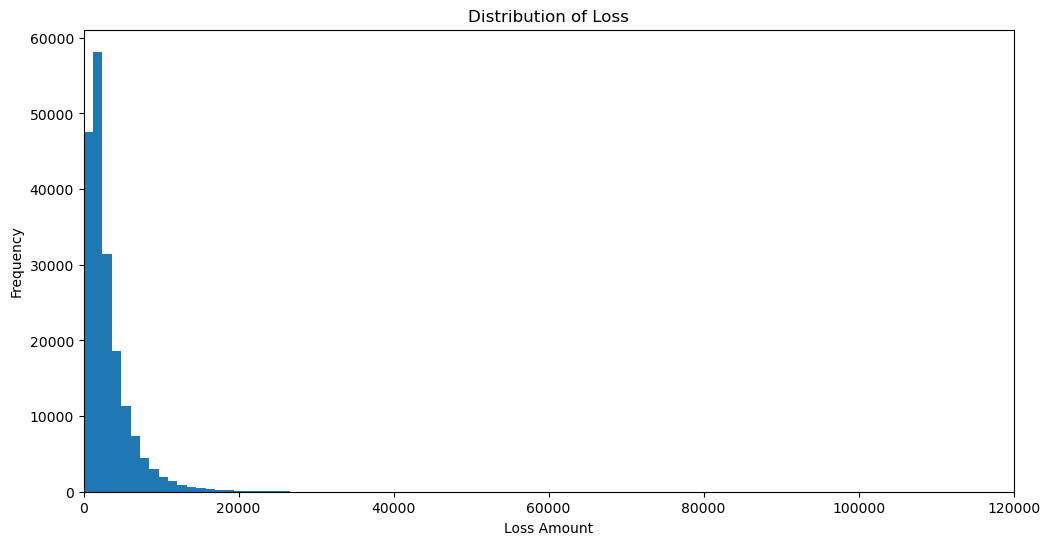

In [7]:
# Loss visualization
plt.figure(figsize=(12, 6))
plt.hist(data['loss'], bins=100)
plt.title('Distribution of Loss')
plt.xlabel('Loss Amount')
plt.ylabel('Frequency')
plt.xlim(0, 120000)
plt.show()

In [8]:
# Check skewness
print("skew value: ")
print(data['loss'].skew())

skew value: 
3.7949583775378604


In [9]:
# Determine which categorical values cannot be converted to boolean data
categorical = [x for x in data.columns if set(pd.unique(data[x])) != {'A', 'B'} and 'cat' in x]
categorical

['cat73',
 'cat74',
 'cat75',
 'cat76',
 'cat77',
 'cat78',
 'cat79',
 'cat80',
 'cat81',
 'cat82',
 'cat83',
 'cat84',
 'cat85',
 'cat86',
 'cat87',
 'cat88',
 'cat89',
 'cat90',
 'cat91',
 'cat92',
 'cat93',
 'cat94',
 'cat95',
 'cat96',
 'cat97',
 'cat98',
 'cat99',
 'cat100',
 'cat101',
 'cat102',
 'cat103',
 'cat104',
 'cat105',
 'cat106',
 'cat107',
 'cat108',
 'cat109',
 'cat110',
 'cat111',
 'cat112',
 'cat113',
 'cat114',
 'cat115',
 'cat116']

In [10]:
# check unique values
for col in [
    'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79',
    'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86',
    'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93',
    'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100',
    'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106',
    'cat107', 'cat108', 'cat109', 'cat110', 'cat111', 'cat112',
    'cat113', 'cat114', 'cat115', 'cat116'
]:
    print(f"Unique values in {col}: {data[col].unique()}")

Unique values in cat73: ['A' 'B' 'C']
Unique values in cat74: ['A' 'B' 'C']
Unique values in cat75: ['B' 'A' 'C']
Unique values in cat76: ['A' 'C' 'B']
Unique values in cat77: ['D' 'C' 'B' 'A']
Unique values in cat78: ['B' 'A' 'C' 'D']
Unique values in cat79: ['B' 'D' 'A' 'C']
Unique values in cat80: ['D' 'B' 'A' 'C']
Unique values in cat81: ['D' 'B' 'A' 'C']
Unique values in cat82: ['B' 'A' 'D' 'C']
Unique values in cat83: ['D' 'B' 'A' 'C']
Unique values in cat84: ['C' 'A' 'D' 'B']
Unique values in cat85: ['B' 'A' 'C' 'D']
Unique values in cat86: ['D' 'B' 'C' 'A']
Unique values in cat87: ['B' 'C' 'D' 'A']
Unique values in cat88: ['A' 'D' 'E' 'B']
Unique values in cat89: ['A' 'B' 'C' 'E' 'D' 'H' 'I' 'G']
Unique values in cat90: ['A' 'B' 'C' 'D' 'F' 'E' 'G']
Unique values in cat91: ['A' 'B' 'G' 'C' 'D' 'E' 'F' 'H']
Unique values in cat92: ['A' 'H' 'B' 'C' 'D' 'I' 'F']
Unique values in cat93: ['D' 'C' 'A' 'B' 'E']
Unique values in cat94: ['B' 'D' 'C' 'A' 'F' 'E' 'G']
Unique values in cat

In [11]:
# One-hot encoding function
def process_cat(data, cat_features):
    for cat in cat_features:
        # Check if the column exists in the DataFrame before processing
        if cat in data.columns:
            # One-hot encode the categorical feature
            data_cat = pd.get_dummies(data[cat], prefix=cat)

            # Join the new one-hot encoded columns with the original data
            data = data.join(data_cat)

            # Drop the original categorical columns
            data.drop(columns=cat, inplace=True)
        else:
            print(f"Column '{cat}' not found in DataFrame, skipping.") # Print if column not found

    return data

data = process_cat(data, categorical)

In [12]:
# Convert other categorical data into boolean data
for i in range(1, 73):
    data['cat' + str(i)] = data['cat' + str(i)].replace({'A': True, 'B': False})

data


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cat116_P,cat116_Q,cat116_R,cat116_S,cat116_T,cat116_U,cat116_V,cat116_W,cat116_X,cat116_Y
0,1,True,False,True,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,True,False,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,5,True,False,True,True,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,10,False,False,True,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
4,11,True,False,True,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,587620,True,False,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
188314,587624,True,True,True,True,True,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
188315,587630,True,False,True,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
188316,587632,True,False,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
# Check for non-numeric columns
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

# Display remaining categorical columns
print("Remaining categorical columns:", categorical_columns)

Remaining categorical columns: Index([], dtype='object')


In [14]:
# Remove 'id' as it’s not a useful feature for the model, and 'loss' is the target variable
X = data.drop(columns=['id', 'loss'])
y = data['loss']

In [15]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Split training set to create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [17]:
# mean baseline model
mean_pred = np.full_like(y_test, fill_value=np.mean(y_train), dtype=np.float64)
mse_mean = mean_squared_error(y_test, mean_pred)
rmse_mean = np.sqrt(mse_mean)
print(f"Baseline RMSE (Mean Model): {rmse_mean:.4f}")

Baseline RMSE (Mean Model): 2856.5220


In [18]:
# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [19]:
# Set the parameters
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression
    'learning_rate': 0.1,
    'random_state': 42,
    'gamma': 0.1,
}

In [20]:
# Train the XGBoost
model = xgb.train(
    params,
    dtrain,
    num_boost_round=550,
    evals=[(dval, 'eval'), (dtest, 'test')],
    early_stopping_rounds=20,
    verbose_eval=True
)

[0]	eval-rmse:2823.79408	test-rmse:2738.82765
[1]	eval-rmse:2724.80934	test-rmse:2638.73317
[2]	eval-rmse:2639.47652	test-rmse:2552.66493
[3]	eval-rmse:2569.69317	test-rmse:2478.10934
[4]	eval-rmse:2510.46846	test-rmse:2415.54676
[5]	eval-rmse:2458.80727	test-rmse:2360.30408
[6]	eval-rmse:2413.85923	test-rmse:2313.22627
[7]	eval-rmse:2375.86847	test-rmse:2271.90139
[8]	eval-rmse:2335.40299	test-rmse:2236.51624
[9]	eval-rmse:2304.89576	test-rmse:2204.80425
[10]	eval-rmse:2277.28798	test-rmse:2174.24681
[11]	eval-rmse:2254.93847	test-rmse:2149.89953
[12]	eval-rmse:2234.49597	test-rmse:2128.63262
[13]	eval-rmse:2215.56678	test-rmse:2108.09989
[14]	eval-rmse:2198.58184	test-rmse:2090.22638
[15]	eval-rmse:2184.04650	test-rmse:2073.65444
[16]	eval-rmse:2171.93262	test-rmse:2059.60441
[17]	eval-rmse:2158.03978	test-rmse:2049.22070
[18]	eval-rmse:2144.68879	test-rmse:2036.48849
[19]	eval-rmse:2136.31643	test-rmse:2025.95263
[20]	eval-rmse:2126.04851	test-rmse:2017.52891
[21]	eval-rmse:2115.884

In [21]:
# Predict on the test set
y_pred = model.predict(dtest)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test MAE: {mae:.4f}")

#Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Test RMSE: {rmse:.4f}")

Test MAE: 1179.7505
Test RMSE: 1844.2576


In [22]:
# Perform cross-validation
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=550,
    nfold=3,
    early_stopping_rounds=20,
    metrics="rmse",
)

print(f"Cross-Validation RMSE: {cv_results['test-rmse-mean'].min():.4f}")

Cross-Validation RMSE: 1929.9522


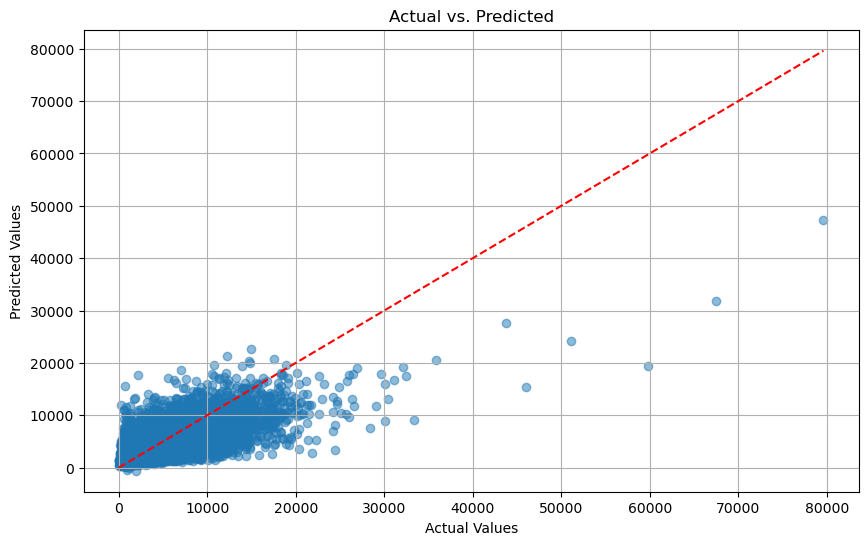

In [23]:
# Visualizing Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [24]:
# Randomized Search for hyperparameter tuning
param_distributions = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

In [25]:
random_search = RandomizedSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'),  
                                   param_distributions=param_distributions,
                                   n_iter=50,
                                   cv=3,
                                   verbose=2,
                                   random_state=42)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END learning_rate=0.1, max_depth=None, n_estimators=10, subsample=1.0; total time=   3.4s
[CV] END learning_rate=0.1, max_depth=None, n_estimators=10, subsample=1.0; total time=   4.1s
[CV] END learning_rate=0.1, max_depth=None, n_estimators=10, subsample=1.0; total time=   3.4s
[CV] END learning_rate=0.2, max_depth=20, n_estimators=10, subsample=1.0; total time=   9.5s
[CV] END learning_rate=0.2, max_depth=20, n_estimators=10, subsample=1.0; total time=   7.8s
[CV] END learning_rate=0.2, max_depth=20, n_estimators=10, subsample=1.0; total time=  10.4s
[CV] END learning_rate=0.2, max_depth=20, n_estimators=10, subsample=0.8; total time=   9.6s
[CV] END learning_rate=0.2, max_depth=20, n_estimators=10, subsample=0.8; total time=   8.2s
[CV] END learning_rate=0.2, max_depth=20, n_estimators=10, subsample=0.8; total time=  13.7s
[CV] END learning_rate=0.01, max_depth=20, n_estimators=10, subsample=0.8; total time=  11.4s
[

In [26]:
best_model = random_search.best_estimator_

In [54]:
# Fit the best model on the training data
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE: {test_rmse:.4f}")

RMSE: 1857.1311


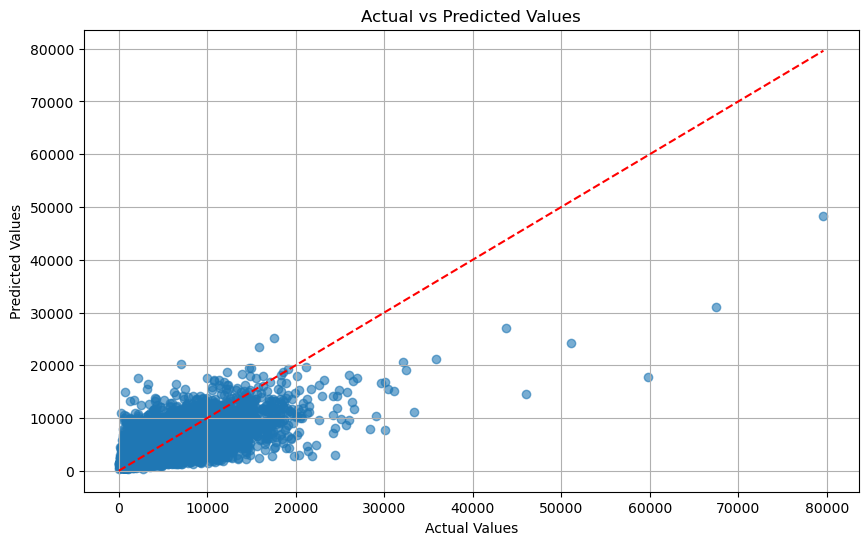

In [56]:

y_pred = random_search.best_estimator_.predict(X_test)  

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()